In [2]:
import numpy as np
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
from copy import deepcopy

# Dataset

- **Name**: name of appliance
- **Type**: non-shiftable (NS), power-shiftable operable at different power levels (PS), time-shiftable operable at any time slot within normal working slots (TS)
- **Diss.Coeff.**: dissatisfaction coefficient / factor determining weightage of deviation from maximum power level for power shiftable appliances and from earliest normal working slot (waiting time) for time shiftable appliances
- **Power rating**: appliance's power levels
- **Time Slot**: normal working slots for each appliance

In [3]:
num_slots = 24

In [4]:
appliance_data = [['Fridge-Freezer', 'NS', 100, 0.08, [1, num_slots]], 
                  ['Washing Machine', 'TS', 0.1, 2, [20, 22]],  
                  ['Over Head Fan', 'PS', 0.05, [0.04, 0.08, 0.01], [1, num_slots]], 
                  ['Micro Wave', 'NS', 100, 1.2, [20, 21]],
                  ['Kettle', 'NS', 100, 2.5, [20, 21]],
                  ['Toaster', 'NS', 100, 1.2, [20, 21]],
                  ['Television', 'NS', 100, .05, [20, 21]],
                  ['Dish Washer', 'TS', 0.06, 2, [20, 21]]]
  
appliance_df = pd.DataFrame(appliance_data, columns=['Name', 'Type', 'Diss. Coeff.', 'Power Rating (kWh)', 'Time Slot'])
appliance_df

appliance_df = appliance_df.sort_values('Diss. Coeff.', ascending = False)
appliance_df

,Name,Type,Diss. Coeff.,Power Rating (kWh),Time Slot
0,Fridge-Freezer,NS,100.00,0.08,"[1, 24]"
3,Micro Wave,NS,100.00,1.2,"[20, 21]"
4,Kettle,NS,100.00,2.5,"[20, 21]"
5,Toaster,NS,100.00,1.2,"[20, 21]"
6,Television,NS,100.00,0.05,"[20, 21]"
1,Washing Machine,TS,0.10,2,"[20, 22]"
7,Dish Washer,TS,0.06,2,"[20, 21]"
2,Over Head Fan,PS,0.05,"[0.04, 0.08, 0.01]","[1, 24]"


# Electricity Price

In [5]:
elec_price = [7,
 7,
 12.550671918691723,
 7,
 12.739062380643254,
 14.992288969506301,
 14.49843505098006,
 24.48273043397385,
 26.049971534410666,
 30.085076802796124,
 39.86924098254647,
 44.568079207321354,
 44.031097878028774,
 43.11204585286087,
 33.1910857632729,
 27.839081174545584,
 22.900078916319405,
 18.198173527369615,
 18.26506388662922,
 15.442867378453435,
 11.83291840424658,
 7.494176244631234,
 10.134256986273279,
 9.82618331498804]

states=elec_price
states


[7,
 7,
 12.550671918691723,
 7,
 12.739062380643254,
 14.992288969506301,
 14.49843505098006,
 24.48273043397385,
 26.049971534410666,
 30.085076802796124,
 39.86924098254647,
 44.568079207321354,
 44.031097878028774,
 43.11204585286087,
 33.1910857632729,
 27.839081174545584,
 22.900078916319405,
 18.198173527369615,
 18.26506388662922,
 15.442867378453435,
 11.83291840424658,
 7.494176244631234,
 10.134256986273279,
 9.82618331498804]

In [7]:
agents = appliance_df['Name'].tolist()
agent_actions = {}
for agent in agents:
    agent_data = appliance_df.loc[appliance_df['Name'] == agent]
    if (agent_data['Type'] == 'NS').bool():
        agent_actions[agent] = ['on']
    elif (agent_data['Type'] == 'PS').bool():
        pr = agent_data['Power Rating (kWh)'].tolist()[0]
        agent_actions[agent] = [round(i, 10) for i in np.arange(pr[0], pr[1] + pr[2], pr[2])]
    elif (agent_data['Type'] == 'TS').bool():
        agent_actions[agent] = ['on', 'off']
agent_actions

{'Fridge-Freezer': ['on'],
 'Micro Wave': ['on'],
 'Kettle': ['on'],
 'Toaster': ['on'],
 'Television': ['on'],
 'Washing Machine': ['on', 'off'],
 'Dish Washer': ['on', 'off'],
 'Over Head Fan': [0.04, 0.05, 0.06, 0.07, 0.08]}

In [8]:
def in_slot(t, ts):
    if t + 1 >= ts[0] and t + 1 <= ts[1]:
            '''print (t+1,ts[0],ts[1])'''
            return True
    return False

In [9]:
without_DR_actions = {}
for t in range(num_slots):
    without_DR_actions[t] = {}
    for agent in agents:
        without_DR_actions[t][agent] = None
        act = None
        agent_data = appliance_df.loc[appliance_df['Name'] == agent]
        if (agent_data['Type'] == 'NS').bool():
            ts = agent_data['Time Slot'].tolist()[0]
            if in_slot(t, ts):
                pr = agent_data['Power Rating (kWh)'].tolist()[0]
                act = 'on'
        elif (agent_data['Type'] == 'PS').bool():
            ts = agent_data['Time Slot'].tolist()[0]
            if in_slot(t, ts):
                pr = agent_data['Power Rating (kWh)'].tolist()[0]
                act = pr[1]
        elif (agent_data['Type'] == 'TS').bool():
            ts = agent_data['Time Slot'].tolist()[0]
            if in_slot(t, ts):
                pr = agent_data['Power Rating (kWh)'].tolist()[0]
                if t + 1 == ts[0]:
                    act = 'on'
                else:
                    act = 'off'
        without_DR_actions[t][agent] = act

# Multi-Agent Q Learning

Agents take that action which maximizes their own expected cumulative reward.

In [10]:
cols = ['Name', 'Type', 'Diss. Coeff.', 'Power Rating (kWh)', 'Time Slot']

def get_reward_DR(st, t, agent, act, started):
    reward = 0.0
    cost = 0.0
    agent_data = appliance_df.loc[appliance_df['Name'] == agent]
    if (agent_data['Type'] == 'NS').bool():
        ts = agent_data['Time Slot'].tolist()[0]
        if in_slot(t, ts):
            pr = agent_data['Power Rating (kWh)'].tolist()[0]
            reward = (-st * max(0, (pr)))
            cost = (-st * max(0, (pr)))
    elif (agent_data['Type'] == 'PS').bool():
        ts = agent_data['Time Slot'].tolist()[0]
        if in_slot(t, ts):
            pr = agent_data['Power Rating (kWh)'].tolist()[0]
            dc = agent_data['Diss. Coeff.'].tolist()[0]
            reward = ((-st * max(0, (act))) - (dc * math.pow(pr[1] - act, 2)))
            cost = (-st * max(0, (act)))
    elif (agent_data['Type'] == 'TS').bool():
        ts = agent_data['Time Slot'].tolist()[0]
        if in_slot(t, ts):
            pr = agent_data['Power Rating (kWh)'].tolist()[0]
            dc = agent_data['Diss. Coeff.'].tolist()[0]
            if (act == 'on' or (t + 1 == ts[1])) and started[agent] != 1:
                reward = - (st * max(0, pr) - (dc * math.pow(ts[0] - t - 1, 2)))
                cost = (-st * max(0, (pr)))
                started[agent] = 1
    return round(reward, 6), cost, started

def get_reward_without_DR(st, t, agent):
    reward = 0.0
    cost = 0.0
    agent_data = appliance_df.loc[appliance_df['Name'] == agent]
    if (agent_data['Type'] == 'NS').bool():
        ts = agent_data['Time Slot'].tolist()[0]
        if in_slot(t, ts):
            pr = agent_data['Power Rating (kWh)'].tolist()[0]
            reward = (-st * max(0, (pr)))
            cost = (-st * max(0, (pr)))
    elif (agent_data['Type'] == 'PS').bool():
        ts = agent_data['Time Slot'].tolist()[0]
        if in_slot(t, ts):
            pr = agent_data['Power Rating (kWh)'].tolist()[0]
            reward = (-st * max(0, (pr[1])))
            cost = (-st * max(0, (pr[1])))

    elif (agent_data['Type'] == 'TS').bool():
        ts = agent_data['Time Slot'].tolist()[0]
        if in_slot(t, ts):
            pr = agent_data['Power Rating (kWh)'].tolist()[0]
            if t + 1 == ts[0]:
                reward = - (st * max(0, pr))
                cost = - (st * max(0, pr))
    return round(reward, 6), cost


started = {}
for agent in agents:
        started[agent] = 0
print(get_reward_DR(states[21], 21, 'Washing Machine', 'on', started))
print(get_reward_without_DR(states[21], 21, 'Washing Machine'))

(-14.588352, -14.988352489262468, {'Fridge-Freezer': 0, 'Micro Wave': 0, 'Kettle': 0, 'Toaster': 0, 'Television': 0, 'Washing Machine': 1, 'Dish Washer': 0, 'Over Head Fan': 0})
(0.0, 0.0)


In [11]:
num_timeslots = num_slots
num_episodes = 1000
epsilon = 0.3

gamma = 0.9
theta = 0.3

converged = 1
threshold = 0.001

recommendations = {}
actually_started = {}

for t in range(num_timeslots):
    actually_started[t] = {}
    for agent in agents:
        actually_started[t][agent] = 0

started = {}
for agent in agents:
        started[agent] = 0

Without_DR_total_reward = 0.0
With_DR_total_reward = 0.0

Without_DR_total_electricity_cost = 0.0
With_DR_total_electricity_cost = 0.0

average_time = 0

for t in range(num_timeslots):
    print('Slot: ', t + 1)
    start = time.time()
    recommendations[t] = {}
    Q = {}
    Q_prev = {}
    R = {}
    C = {}
    for st in states:
        Q[st] = {}
        Q_prev[st] = {}
        R[st] = {}
        C[st] = {}
        for agent in agents:
            Q[st][agent] = {}
            Q_prev[st][agent] = {}
            R[st][agent] = {}
            C[st][agent] = {}
            recommendations[t][agent] = None
    converged = 1
    for agent in agents:
        print('Appliance: ', agent)
        for st in states:
            for act in agent_actions[agent]:
                Q[st][agent][act] = 0.0
                Q_prev[st][agent][act] = 0.0
        if t > 0:
            started[agent] = actually_started[t - 1][agent]
        else:
            started[agent] = 0
        for eps in range(num_episodes):
            if t > 0:
                if actually_started[t-1][agent] != 1:
                    started[agent] = 0
            else:
                started[agent] = 0
            Q_prev = deepcopy(Q)
            st = states[t]
            itr = 0
            curr_t = t
            while curr_t < num_slots - 1:
                p = np.random.random()
                if p < epsilon:
                    j = np.random.choice(len(agent_actions[agent]))
                else:
                    j = np.argmax([Q[st][agent][a] for a in agent_actions[agent]])
                at = agent_actions[agent][j]
                sdash = states[curr_t + 1]
                R[st][agent][at], C[st][agent][at], started = get_reward_DR(st, curr_t, agent, at, started)
                Q[st][agent][at] = Q[st][agent][at] + theta * (R[st][agent][at] + gamma * max([Q[sdash][agent][act] for act in agent_actions[agent]]) - Q[st][agent][at]) 
                st = sdash
                curr_t += 1
            converged = 1
            for s in states:
                for a in agent_actions[agent]:
                    if abs(Q[s][agent][a] - Q_prev[s][agent][a]) > threshold:
                        converged = 0
            if converged == 1:
                conv_eps = eps
                break
        recommendations[t][agent] = agent_actions[agent][np.argmax([Q[states[t]][agent][a] for a in agent_actions[agent]])]
        agent_data = appliance_df.loc[appliance_df['Name'] == agent]
        slot = agent_data['Time Slot'].tolist()[0]
        if not in_slot(t, slot):
            recommendations[t][agent] = None
        if (appliance_df.loc[appliance_df['Name'] == agent]['Type'] == 'TS').bool() and actually_started[t][agent] == 1:
            recommendations[t][agent] = 'off'
        if recommendations[t][agent] == 'on' and (appliance_df.loc[appliance_df['Name'] == agent]['Type'] == 'TS').bool():
            if t + 1 < num_timeslots:
                actually_started[t + 1][agent] = 1
        if recommendations[t][agent] == 'off' and (appliance_df.loc[appliance_df['Name'] == agent]['Type'] == 'TS').bool() and actually_started[t][agent] == 0 and t + 1 ==  slot[1]:
            if t + 1 < num_timeslots: 
                actually_started[t + 1][agent] = 1
            recommendations[t][agent] = 'on'
    print(converged)
    end = time.time()
    print('Time taken to recommend (s): ', end-start)
    average_time += (end-start)
    print("Slot: ", t + 1, " | Recommendations: ", recommendations[t])


Slot:  1
Appliance:  Fridge-Freezer
Appliance:  Micro Wave
Appliance:  Kettle
Appliance:  Toaster
Appliance:  Television
Appliance:  Washing Machine
Appliance:  Dish Washer
Appliance:  Over Head Fan
1
Time taken to recommend (s):  47.04789996147156
Slot:  1  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.05}
Slot:  2
Appliance:  Fridge-Freezer
Appliance:  Micro Wave
Appliance:  Kettle
Appliance:  Toaster
Appliance:  Television
Appliance:  Washing Machine
Appliance:  Dish Washer
Appliance:  Over Head Fan
0
Time taken to recommend (s):  51.10504627227783
Slot:  2  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.05}
Slot:  3
Appliance:  Fridge-Freezer
Appliance:  Micro Wave
Appliance:  Kettle
Appliance:  Toaster
Appliance:

Appliance:  Dish Washer
Appliance:  Over Head Fan
1
Time taken to recommend (s):  9.226176023483276
Slot:  19  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.04}
Slot:  20
Appliance:  Fridge-Freezer
Appliance:  Micro Wave
Appliance:  Kettle
Appliance:  Toaster
Appliance:  Television
Appliance:  Washing Machine
Appliance:  Dish Washer
Appliance:  Over Head Fan
1
Time taken to recommend (s):  7.199913263320923
Slot:  20  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': 'on', 'Kettle': 'on', 'Toaster': 'on', 'Television': 'on', 'Washing Machine': 'off', 'Dish Washer': 'off', 'Over Head Fan': 0.04}
Slot:  21
Appliance:  Fridge-Freezer
Appliance:  Micro Wave
Appliance:  Kettle
Appliance:  Toaster
Appliance:  Television
Appliance:  Washing Machine
Appliance:  Dish Washer
Appliance:  Over Head Fan
1
Time taken to recommend (s):  2.4691860675811768
S

In [12]:
Appliance_Without_DR_Cost = {}
Appliance_With_DR_Cost = {}

Timeslot_Without_DR_Cost = {}
Timeslot_With_DR_Cost = {}

Appliance_Without_DR_Reward = {}
Appliance_With_DR_Reward = {}

Without_DR_total_reward = 0
With_DR_total_reward = 0
Without_DR_total_electricity_cost = 0
With_DR_total_electricity_cost = 0

for agent in agents:
    Appliance_Without_DR_Cost[agent] = 0
    Appliance_With_DR_Cost[agent] = 0
    Appliance_Without_DR_Reward[agent] = 0
    Appliance_With_DR_Reward[agent] = 0

for t in range(num_timeslots):
    Timeslot_Without_DR_Cost[t] = 0
    Timeslot_With_DR_Cost[t] = 0
    for agent in agents:
        temp = deepcopy(actually_started)

        rew, c, actually_started[t] = get_reward_DR(states[t], t, agent, recommendations[t][agent], actually_started[t])
        actually_started = temp
        With_DR_total_reward += rew
        Appliance_With_DR_Reward[agent] -= rew
        With_DR_total_electricity_cost += c
        Appliance_With_DR_Cost[agent] -= c
        Timeslot_With_DR_Cost[t] -= c

        rew, c = get_reward_without_DR(states[t], t, agent)
        Without_DR_total_reward += rew
        Appliance_Without_DR_Reward[agent] -= rew
        Without_DR_total_electricity_cost += c
        Appliance_Without_DR_Cost[agent] -= c
        Timeslot_Without_DR_Cost[t] -= c

In [13]:
for t in range(num_timeslots):
    print("Slot: ", t + 1, " | Recommendations: ", recommendations[t])
    print("Slot: ", t + 1, " | Original Actions: ", without_DR_actions[t])
    print()

Slot:  1  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.05}
Slot:  1  | Original Actions:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.08}

Slot:  2  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.05}
Slot:  2  | Original Actions:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.08}

Slot:  3  | Recommendations:  {'Fridge-Freezer': 'on', 'Micro Wave': None, 'Kettle': None, 'Toaster': None, 'Television': None, 'Washing Machine': None, 'Dish Washer': None, 'Over Head Fan': 0.04}
Slot:  3  |

In [14]:
from IPython.display import display
recom_data = {}
Recom_df = {}
for agent in agents:
    print('\n\nAppliance: ', agent, ' | Dis. Coef.: ', appliance_df.loc[appliance_df['Name'] == agent]['Diss. Coeff.'].tolist()[0])
    recom_data[agent] = [[t+1, without_DR_actions[t][agent], recommendations[t][agent], states[t]] for t in range(num_timeslots)]
    Recom_df[agent] = pd.DataFrame(recom_data[agent], columns=['Slot', 'Action without DR', 'Action with DR', 'Elec. Price ($/KW)'])
    display(Recom_df[agent])



Appliance:  Fridge-Freezer  | Dis. Coef.:  100.0


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,on,on,7.000000
1,2,on,on,7.000000
2,3,on,on,12.550672
3,4,on,on,7.000000
4,5,on,on,12.739062
5,6,on,on,14.992289
6,7,on,on,14.498435
7,8,on,on,24.482730
8,9,on,on,26.049972
9,10,on,on,30.085077




Appliance:  Micro Wave  | Dis. Coef.:  100.0


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,None,None,7.000000
1,2,None,None,7.000000
2,3,None,None,12.550672
3,4,None,None,7.000000
4,5,None,None,12.739062
5,6,None,None,14.992289
6,7,None,None,14.498435
7,8,None,None,24.482730
8,9,None,None,26.049972
9,10,None,None,30.085077




Appliance:  Kettle  | Dis. Coef.:  100.0


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,None,None,7.000000
1,2,None,None,7.000000
2,3,None,None,12.550672
3,4,None,None,7.000000
4,5,None,None,12.739062
5,6,None,None,14.992289
6,7,None,None,14.498435
7,8,None,None,24.482730
8,9,None,None,26.049972
9,10,None,None,30.085077




Appliance:  Toaster  | Dis. Coef.:  100.0


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,None,None,7.000000
1,2,None,None,7.000000
2,3,None,None,12.550672
3,4,None,None,7.000000
4,5,None,None,12.739062
5,6,None,None,14.992289
6,7,None,None,14.498435
7,8,None,None,24.482730
8,9,None,None,26.049972
9,10,None,None,30.085077




Appliance:  Television  | Dis. Coef.:  100.0


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,None,None,7.000000
1,2,None,None,7.000000
2,3,None,None,12.550672
3,4,None,None,7.000000
4,5,None,None,12.739062
5,6,None,None,14.992289
6,7,None,None,14.498435
7,8,None,None,24.482730
8,9,None,None,26.049972
9,10,None,None,30.085077




Appliance:  Washing Machine  | Dis. Coef.:  0.1


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,None,None,7.000000
1,2,None,None,7.000000
2,3,None,None,12.550672
3,4,None,None,7.000000
4,5,None,None,12.739062
5,6,None,None,14.992289
6,7,None,None,14.498435
7,8,None,None,24.482730
8,9,None,None,26.049972
9,10,None,None,30.085077




Appliance:  Dish Washer  | Dis. Coef.:  0.06


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,None,None,7.000000
1,2,None,None,7.000000
2,3,None,None,12.550672
3,4,None,None,7.000000
4,5,None,None,12.739062
5,6,None,None,14.992289
6,7,None,None,14.498435
7,8,None,None,24.482730
8,9,None,None,26.049972
9,10,None,None,30.085077




Appliance:  Over Head Fan  | Dis. Coef.:  0.05


,Slot,Action without DR,Action with DR,Elec. Price ($/KW)
0,1,0.08,0.05,7.000000
1,2,0.08,0.05,7.000000
2,3,0.08,0.04,12.550672
3,4,0.08,0.04,7.000000
4,5,0.08,0.04,12.739062
5,6,0.08,0.04,14.992289
6,7,0.08,0.04,14.498435
7,8,0.08,0.04,24.482730
8,9,0.08,0.04,26.049972
9,10,0.08,0.04,30.085077


In [69]:
appliance_df

,Name,Type,Diss. Coeff.,Power Rating (kWh),Time Slot
0,Fridge-Freezer,NS,100.00,0.08,"[1, 24]"
3,Micro Wave,NS,100.00,1.2,"[20, 21]"
4,Kettle,NS,100.00,2.5,"[20, 21]"
5,Toaster,NS,100.00,1.2,"[20, 21]"
6,Television,NS,100.00,0.05,"[20, 21]"
1,Washing Machine,TS,0.10,2,"[20, 22]"
7,Dish Washer,TS,0.06,2,"[20, 21]"
2,Over Head Fan,PS,0.05,"[0.04, 0.08, 0.01]","[1, 24]"


## Assuming Recommendations are followed, cost with and w/o Demand Response

In [23]:
print('\n\nTotal reward without DR: ', Without_DR_total_reward)
print('Total reward with DR: ', With_DR_total_reward)

print('Total electricity cost without DR: ', -Without_DR_total_electricity_cost)
print('Total electricity cost with DR: ', -With_DR_total_electricity_cost)

print ('Cost Saving =',round (With_DR_total_reward-Without_DR_total_reward,1),'$' )

print('Average Recommendation Time: ', average_time / num_timeslots)



Total reward without DR:  -277.28302100000013
Total reward with DR:  -233.873311
Total electricity cost without DR:  277.28302299553695
Total electricity cost with DR:  234.33152284003202
Cost Saving = 43.4 $
Average Recommendation Time:  20.5512735247612


In [22]:
print ('Cost Saving =',round (With_DR_total_reward-Without_DR_total_reward,1),'$' )

Cost Saving = 43.4 $


In [24]:
dc = appliance_df['Diss. Coeff.'].tolist()
DC = {}
i = 0
for agent in agents:
    DC[agent] = dc[i]
    i += 1

In [34]:
data = [[agent, Appliance_Without_DR_Cost[agent], Appliance_With_DR_Cost[agent], DC[agent]] for agent in agents]
  
data.append(['Total', -Without_DR_total_electricity_cost, -With_DR_total_electricity_cost])
DR_df = pd.DataFrame(data, columns=['Name', 'Cost without DR (cents)', 'Cost with DR (cents)', 'Diss. Coef.'])
DR_df

,Name,Cost without DR (cents),Cost with DR (cents),Diss. Coef.
0,Fridge-Freezer,40.248207,40.248207,100.00
1,Micro Wave,32.730943,32.730943,100.00
2,Kettle,68.189464,68.189464,100.00
3,Toaster,32.730943,32.730943,100.00
4,Television,1.363789,1.363789,100.00
5,Washing Machine,30.885735,14.988352,0.10
6,Dish Washer,30.885735,23.665837,0.06
7,Over Head Fan,40.248207,20.413987,0.05
8,Total,277.283023,234.331523,NaN


In [35]:
ts_data = [[t+1, Timeslot_Without_DR_Cost[t], Timeslot_With_DR_Cost[t], states[t], Timeslot_Without_DR_Cost[t]/states[t], Timeslot_With_DR_Cost[t]/states[t]] for t in range(num_timeslots)]
TS_df = pd.DataFrame(ts_data, columns=['Slot', 'Cost without DR (cents)', 'Cost with DR (cents)', 'Elec. Price ($/kWk)', 'Power Con. without DR (kWh)', 'Power Con. with DR (kWh)'])

TS_df

,Slot,Cost without DR (cents),Cost with DR (cents),Elec. Price ($/kWk),Power Con. without DR (kWh),Power Con. with DR (kWh)
0,1,1.120000,0.910000,7.000000,0.16,0.13
1,2,1.120000,0.910000,7.000000,0.16,0.13
2,3,2.008108,1.506081,12.550672,0.16,0.12
3,4,1.120000,0.840000,7.000000,0.16,0.12
4,5,2.038250,1.528687,12.739062,0.16,0.12
5,6,2.398766,1.799075,14.992289,0.16,0.12
6,7,2.319750,1.739812,14.498435,0.16,0.12
7,8,3.917237,2.937928,24.482730,0.16,0.12
8,9,4.167995,3.125997,26.049972,0.16,0.12
9,10,4.813612,3.610209,30.085077,0.16,0.12


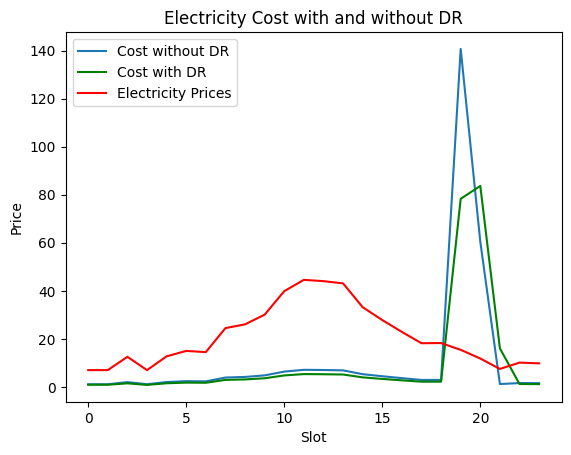

In [36]:
prices  = []
without_DR = []
with_DR = []
for t in range(num_timeslots):
    prices.append(states[t])
    with_DR.append(Timeslot_With_DR_Cost[t])
    without_DR.append(Timeslot_Without_DR_Cost[t])
plt.title('Electricity Cost with and without DR')
plt.xlabel('Slot')
plt.ylabel('Price')
plt.plot(range(num_timeslots), without_DR, label="Cost without DR")
plt.plot(range(num_timeslots), with_DR, label="Cost with DR", color='g')
plt.plot(range(num_timeslots), prices, label="Electricity Prices", color='r')
plt.legend()

In [37]:
Q

{7: {'Fridge-Freezer': {'on': 0.0},
  'Micro Wave': {'on': 0.0},
  'Kettle': {'on': 0.0},
  'Toaster': {'on': 0.0},
  'Television': {'on': 0.0},
  'Washing Machine': {'on': 0.0, 'off': 0.0},
  'Dish Washer': {'on': 0.0, 'off': 0.0},
  'Over Head Fan': {0.04: 0.0, 0.05: 0.0, 0.06: 0.0, 0.07: 0.0, 0.08: 0.0}},
 12.550671918691723: {'Fridge-Freezer': {'on': 0.0},
  'Micro Wave': {'on': 0.0},
  'Kettle': {'on': 0.0},
  'Toaster': {'on': 0.0},
  'Television': {'on': 0.0},
  'Washing Machine': {'on': 0.0, 'off': 0.0},
  'Dish Washer': {'on': 0.0, 'off': 0.0},
  'Over Head Fan': {0.04: 0.0, 0.05: 0.0, 0.06: 0.0, 0.07: 0.0, 0.08: 0.0}},
 12.739062380643254: {'Fridge-Freezer': {'on': 0.0},
  'Micro Wave': {'on': 0.0},
  'Kettle': {'on': 0.0},
  'Toaster': {'on': 0.0},
  'Television': {'on': 0.0},
  'Washing Machine': {'on': 0.0, 'off': 0.0},
  'Dish Washer': {'on': 0.0, 'off': 0.0},
  'Over Head Fan': {0.04: 0.0, 0.05: 0.0, 0.06: 0.0, 0.07: 0.0, 0.08: 0.0}},
 14.992288969506301: {'Fridge-Freeze